In [1]:
from collections import Counter
from munch import munchify
from matplotlib import pyplot as plt
import numpy as np

NUM_CLIMBS = 54
CLIMB_RANGE = list(range(1, NUM_CLIMBS + 1))

In [2]:
def yield_climbs(climb_no, attempts):
    def to_int(txt):
        if txt == 'NA':
            return 0
        return int(txt)
    attempts = to_int(attempts)
    completed = attempts >= 0
    attempts = abs(attempts)
    
    if climb_no.isdigit():
        yield {
            'number': int(climb_no),
            'attempts': attempts,
            'completed': completed
        }
    elif climb_no[0] == '{' and climb_no[-1] == '}':
        # Climb number can be {s:e} e.g "{1-9}"
        start, end = tuple(map(int, climb_no[1:-1].split('-')))
        for climb_no in range(start, end + 1):
            yield {
                'number': int(climb_no),
                'value': int(climb_no),
                'attempts': attempts,
                'completed': completed
            }
    else:
        raise ValueError('climb_no "{}" is malformatted'.format(climb_no))
        
        


def load_data(fpath):
    data = []
    with open(fpath) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            entries = list(map(lambda txt: txt.strip(), line.split('\t')))
            competition_type, name, gender, category = tuple(entries[:4])
            gender = {'m': 'male', 'f': 'female'}[gender.lower()]
            
            if category:
                category = {
                    'r': 'recreational', 
                    'i': 'intermediate',
                    'a': 'advanced'
                }[category.lower()]
            else:
                category = None
            climb_data = [ent for ent in entries[4:] if ent.strip()]
            if len(climb_data) % 2 != 0:
                raise ValueError('Line "{}" is malformatted'.format(line))
            climbs = []
            
            for i in range(0, len(climb_data), 2):
                climbs += list(yield_climbs(climb_data[i], climb_data[i + 1]))

            
            top_climbs = sorted(
                filter(lambda d: d['completed'], climbs), 
                key=lambda d: d['number'], 
                reverse=True
            )[:5]
            
            
            climbs = [
                {**climb_obj, **{'top_5': climb_obj in top_climbs}} 
                for climb_obj in climbs
            ]
            
            
            score = sum([
                cobj['number'] * 100 
                for cobj in climbs if cobj['top_5']
            ])
            
            attempts = sum([
                cobj['attempts']
                for cobj in climbs if cobj['top_5']
            ])

            data.append({
                'comp_type': competition_type.lower(),
                'name': name.strip(),
                'category': category,
                'gender': gender,
                'climbs': climbs,
                'score': score,
                'attempts': attempts
            })

    return data
            
data = load_data('data/climbs.tsv')
for climber in data:
    print('Score: {}, Name: {}'.format(climber['score'], climber['name']))
    for climb in climber['climbs']:
        if climb['top_5']:
            print('\t', climb['number'])

Score: 11900, Name: Matt Tyler
	 20
	 21
	 22
	 24
	 32
Score: 14800, Name: Brendon Anderson
	 24
	 29
	 30
	 32
	 33
Score: 14800, Name: Chris Lapointe
	 23
	 24
	 30
	 33
	 38
Score: 24700, Name: Matthew Matera
	 46
	 47
	 49
	 52
	 53
Score: 23900, Name: Zack Soares
	 45
	 46
	 47
	 49
	 52
Score: 12800, Name: Xavier Warves
	 20
	 22
	 24
	 30
	 32
Score: 10200, Name: 
	 17
	 19
	 20
	 22
	 24
Score: 4500, Name: Hal Munger
	 7
	 8
	 9
	 10
	 11
Score: 18200, Name: Jacob Omodee
	 29
	 32
	 36
	 38
	 47
Score: 11400, Name: Dominic Gonzalez
	 1
	 12
	 26
	 36
	 39
Score: 14500, Name: Vincent Chiu
	 22
	 28
	 30
	 31
	 34
Score: 13900, Name: Arnaud Autef
	 23
	 24
	 29
	 30
	 33
Score: 14600, Name: Amaury Sabran
	 22
	 24
	 30
	 33
	 37
Score: 13400, Name: Andy Chen
	 22
	 23
	 24
	 32
	 33
Score: 22800, Name: John Unitworth
	 40
	 43
	 46
	 47
	 52
Score: 23900, Name: Aishi Goel
	 45
	 46
	 47
	 49
	 52
Score: 8600, Name: Becky Weinstein
	 13
	 15
	 16
	 20
	 22
Score: 14500, Name: Cad

# Some useful filters

In [3]:
from munch import munchify


COMP_TYPES = ['competitive', 'community']
GENDER_TYPES = ['male', 'female']
CATEGORIES = COMP_TYPES + GENDER_TYPES

PEOPLE_FILTERS = munchify({
    'competitive': lambda d: d['comp_type'] == 'competitive',
    'community': lambda d: d['comp_type'] == 'community',
    'female': lambda d: d['gender'] == 'female',
    'male': lambda d: d['gender'] == 'male',
    'everyone': lambda d: True
})

CLIMB_FILTERS = munchify({
    'completed': lambda d: d['completed'],
    'top_five': lambda d: d['top_5']
})


def filter_list(fn, data):
    return [row for row in data if fn(row)]


    

# Basic Stats

### How many climbers per category?

In [6]:
for gender in ['male', 'female']:
    for category in ['community', 'competitive']:
        gendered_climbers = filter_list(PEOPLE_FILTERS[gender], data)
        gender_in_category_climbers = filter_list(PEOPLE_FILTERS[category], gendered_climbers)
        print('{:15}{:15}{}'.format(
            category, 
            gender, 
            len(gender_in_category_climbers)
        ))
    

community      male           46
competitive    male           53
community      female         31
competitive    female         35


### Score Distribution

COMPETITIVE
Mean: 32.67272727272727
Range: (6.0, 51.0)


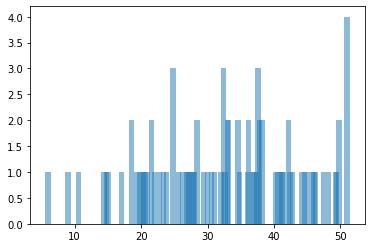

- - - - - - -
COMMUNITY
Mean: 24.96883116883117
Range: (5.2, 50.4)


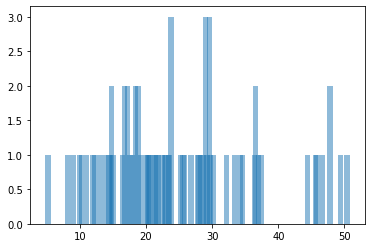

- - - - - - -
FEMALE
Mean: 24.863636363636363
Range: (5.2, 51.0)


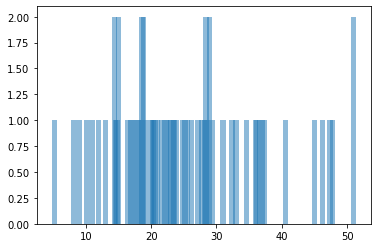

- - - - - - -
MALE
Mean: 31.886868686868684
Range: (6.0, 51.0)


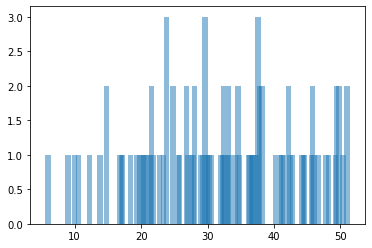

- - - - - - -
EVERYONE
Mean: 29.077575757575758
Range: (5.2, 51.0)


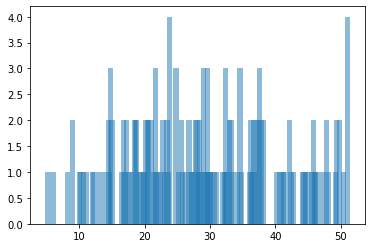

- - - - - - -


In [7]:
def score_statistics(climb_data):
    avg_climbs = [cobj['score'] / 500 for cobj in climb_data]
    mean = np.mean(avg_climbs)
    avg_climb_range = (min(avg_climbs), max(avg_climbs))
    print('Mean: {mean}'.format(**locals()))
    print('Range: {avg_climb_range}'.format(**locals()))
    
    avg_climb_counts = Counter(avg_climbs)
    count_items = avg_climb_counts.items()
    x = [k for k, v in count_items]
    y = [v for k, v in count_items ]
    plt.bar(x, y, align='center', alpha=0.5)
    plt.show()
    
    
    
for category, fltr in PEOPLE_FILTERS.items():
    print(category.upper())
    category_data = filter_list(fltr, data)
    score_statistics(category_data)
    print('- - - - - - -')
    

### Let's Split Climbers into Groups!

In [55]:

highest_climbs = []
target_climb = 47
for climb_obj in data:
    for c in climb_obj['climbs']:
        if c['completed'] and c['number'] == target_climb:
            highest_climbs.append(
                max(climb_obj['climbs'], key=lambda c: c['number'])['number']
            )
print(sum([c == target_climb for c in highest_climbs]))

20


In [51]:
climb_counts = get_climb_counts(
    data,
    filters=[CLIMB_FILTERS.completed]
)
for problem_no, count in climb_counts.items():
    print(problem_no, count)

1 19
2 20
3 18
4 26
5 17
6 22
7 29
8 25
9 26
10 26
11 36
12 43
13 45
14 24
15 38
16 41
17 48
18 29
19 36
20 58
21 18
22 80
23 34
24 47
25 18
26 23
27 10
28 9
29 20
30 61
31 13
32 51
33 64
34 33
35 4
36 18
37 19
38 41
39 4
40 16
41 20
42 12
43 23
44 1
45 11
46 14
47 41
48 11
49 20
50 15
51 6
52 16
53 8
54 0


### What did people climb?

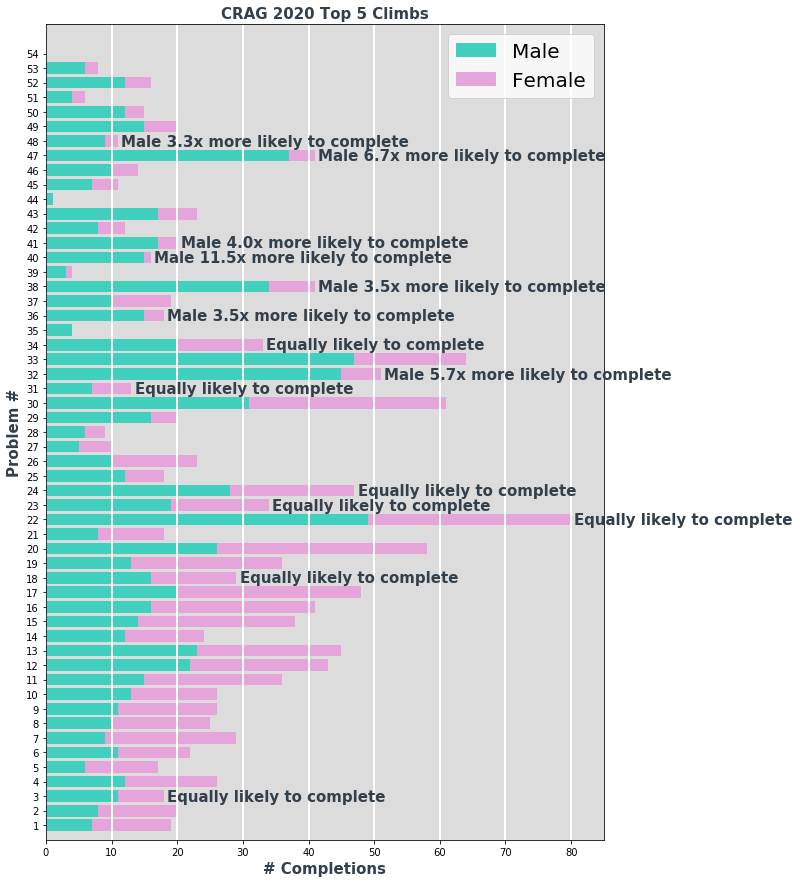

In [44]:
def get_climb_counts(data, filters=[CLIMB_FILTERS.completed]):
    climb_counts = Counter()
    for row in data:
        counted_climbs = row['climbs']
        for fltr_fn in filters:
            counted_climbs = filter_list(fltr_fn, counted_climbs)
        for climb in counted_climbs:
            climb_counts[climb['number']] += 1

    return {
        i: climb_counts[i] for i in CLIMB_RANGE
    }


def plt_settings():
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    
    
FONT_CONFIG = {
    'fontsize': 15,
    'fontweight': 'black',
    'color': "#333F4B"
}

BAR_CONFIGS = {
    'female': {'color': '#E5A4DA'}, 
    'male': {'color': '#41CFBE'}, 
    'competitive': {'color': '#E5A4DA'}, 
    'community': {'color': '#41CFBE'}            
}
    
    


def bar_plot(x_by_category, y, chart_type):
    """
    Praise these sites:
    1) https://python-graph-gallery.com/11-grouped-barplot/
    """
    # x - climb counts by category
    # y - range(1, 55)

    fig_x, fig_y = 10, 15
    fig, ax = plt.subplots(figsize=(fig_x, fig_y))
    
    
    left = [0] * len(y)
    for category, x in x_by_category.items():
        plt.barh(y, x, left=left, **BAR_CONFIGS[category], label=category.capitalize())
        for i, v in enumerate(x):
            left[i] += v
            
    
    for i in range(len(y)):
        y_val = y[i]
        values_by_category = {
            category: x[i] for category, x in x_by_category.items()
        }
        normalized_values_by_category = {
            category: x[i] / sum(x) for category, x in x_by_category.items()
        }
        dominant_category = max(values_by_category.items(), key=lambda kv: kv[1])[0]
        
        num_climbs_in_category = sum(values_by_category.values())
        if num_climbs_in_category == 0:
            dominance = 0
        else:
            dominance = int(round(max(normalized_values_by_category.items(), key=lambda kv: kv[1])[1] / sum(normalized_values_by_category.values()) * 100, 0))
        
        if num_climbs_in_category > 5:
            likelihood = round(dominance / (100 - dominance), 1) if dominance != 100 else 100
            if dominance > 75:
                text = '{} {}x more likely to complete'.format(dominant_category.capitalize(), likelihood)
            elif dominance < 55:
                text = 'Equally likely to complete'
            else:
                text = ''
            plt.text(
                num_climbs_in_category + 0.5, 
                y_val - (fig_x / fig_y / 2), 
                text,
                **FONT_CONFIG
            )



    # Add titles and axis names
    plt.yticks(y)
    plt.title("CRAG 2020 Top 5 Climbs", loc='center', **FONT_CONFIG)
    plt.axis([0, max(left) + 5, 0, max(y) + 2])
    ax.set_ylabel('Problem #', **FONT_CONFIG)
    ax.set_xlabel('# Completions', **FONT_CONFIG)
    ax.set_facecolor('#DCDCDC')
    ax.xaxis.grid(linestyle='-', linewidth=2, color='#FFFFFF')
    
    plt.legend(prop={'size': 20})
    plt.show()


    
    
def listify(d, ordered_keys):
    return [d[k] for k in ordered_keys]

categories = ['male', 'female']
# categories = ['community', 'competitive']
x_by_category = {
    category: listify(
        get_climb_counts(
            filter_list(PEOPLE_FILTERS[category], data),
            filters=[CLIMB_FILTERS.completed]
        ),
        CLIMB_RANGE
    )
    for category in categories
}

y = CLIMB_RANGE


# plt_settings()
bar_plot(x_by_category, y, 'comp_type')


## What climbs did people find the most difficult?

One of the most interesting things we can find in the data is the climbs people found the most difficult. 

When people choose their top 5 climbs they make decisions about what climbs they find relatively easy or enjoyable.

For example, I climbed problems 26, 32, 33, 34, 36. I skipped 35 because I found it difficult and pumpy. I tried 27 and 31 and found them a little stiff for their grade. I didn't try 28, 29 or 30. 

Let's see what we can assess from my choice of climbs. My choice not to climb problems 27, 28, 29, 30, 31 or 35 despite their capacity to increase my score implies that I found those climbs difficult. I am able to climb problems as high as 36. This implies that I found climbs 27 through 31 to be harder than problem 36. 

In addition, I did not climb any climber higher than problem 36. This implies I found all climbs from 37 to 54 to be harder than problem 36.

Given this paradigm, we can model the climbs as a tournament. For example, given the routes I climbed, problems 27, 28, 29, 30, 31 and all those greater than 36 "defeat" problem 36. We then can use the Kendall-Wei method for ranking a tournament to rerank the problems. It's described here (http://www-users.math.umn.edu/~reiner/Classes/Tournaments.pdf) really well.

You may notice that I'm making a few assumptions here - more than difficulty is involved in the choices climbers make. By the time I had finished problem 33 (my final top five problem) I was too tired to work on any more problems. 

Despite these caveats, I think my assumptions are pretty good ones. I found problems 27 and 31 to be similar in difficulty to problems 34 and 36. I found problem 35 harder than problem 36.






In [8]:
from collections import defaultdict
import numpy as np

NUM_CLIMBS = 54
def set_up_tournament(climber_data, max_distance_allowed=25):
    tournament = np.zeros((NUM_CLIMBS, NUM_CLIMBS))
    for climber_obj in climber_data:
        top_climbs = sorted([c['number'] for c in climber_obj['climbs'] if c['top_5']])
        s, e = top_climbs[0], top_climbs[-1]
        if e - s >= max_distance_allowed:
            continue
        
        # All these climbs are harder than the climbs this climber completer
        missed_climbs_in_range = [num for num in range(s, e) if num not in top_climbs]
        higher_climbs = list(range(e + 1, NUM_CLIMBS + 1))
        harder_climbs = missed_climbs_in_range + higher_climbs
        
        # [i][j] += 1 if climb i is harder than climb j
        # Note: zero index the climbs by subtracting 1
        for harder_climb in [c - 1 for c in harder_climbs]:  
            for easier_climb in [c - 1 for c in top_climbs]:
                tournament[harder_climb][easier_climb] +=1

    return tournament


def examine(tournament, climb):
    for i, row in enumerate(tournament):
        if i + 1 != climb: continue
        better_than = {}
        for j, val in enumerate(row):
            if val != 0:
                better_than[j + 1] = val
        print(i + 1, better_than)
        print(sum(better_than.values()))
        
def normalize(np_array):
    return np_array / np.sum(np_array)


def maximum(np_array):
    flattened = np.ndarray.flatten(np_array)
    return max([elem for elem in flattened])

def non_zero_minimum(np_array):
    flattened = np.ndarray.flatten(np_array)
    return min([elem for elem in flattened if elem != 0])

def mean(np_array):
    flattened = np.ndarray.flatten(np_array)
    return sum(flattened) / len(flattened)

        
def rank_tournament(tournament, rounds):
    for i in range(rounds):
        strength_vector = normalize(
            np.reshape(np.ndarray.sum(tournament, 1), (1, len(tournament)))
        )
        tournament = np.multiply(strength_vector, tournament)
        
        if maximum(tournament) > 10 ** 100 or non_zero_minimum(tournament) < 10 ** -100:
            print('Tournament values approaching asymptote. Stopping at round {}'.format(i + 1))
            break
        
    return strength_vector[0]


def sort_by_relative_hardness(rankings):
    # Rankings is a list of problem numbers in ranked order, e.g [2, 3, 5, 4, 1]
    return [
        (problem_no, i + 1 - problem_no) for i, problem_no in 
        sorted(enumerate(rankings), key=lambda kv: kv[1] - kv[0])
    ]

    
tournament = set_up_tournament(data)
raw_rankings = rank_tournament(tournament, 15)
rankings = [i + 1 for i in np.argsort(raw_rankings)]
print('RANKINGS')
for i, climb in enumerate(rankings):
    print('{}) {}'.format(i + 1, climb))


print()
print('EASIEST / HARDEST CLIMBS RELATIVE TO LEVEL')


# Top 10 easiest / hardest climbs relative to level
def relative_diff_string(level_jump):
    if level_jump == 0:
        text = 'rated correctly'
    elif level_jump < 0:
        text = 'rated {} numbers too high'.format(abs(level_jump))
    else:
        text = 'rated {} numbers too low'.format(level_jump)
    return text

hardest_climbs = sort_by_relative_hardness(rankings)
for climb, level_jump in hardest_climbs:
    print('Problem {} was {}'.format(climb, relative_diff_string(level_jump)))



# Top 10 hardest climbs relative to level
        
        


Tournament values approaching asymptote. Stopping at round 7
RANKINGS
1) 1
2) 2
3) 4
4) 6
5) 7
6) 3
7) 5
8) 8
9) 9
10) 10
11) 11
12) 13
13) 12
14) 19
15) 15
16) 14
17) 16
18) 17
19) 18
20) 20
21) 21
22) 22
23) 23
24) 24
25) 26
26) 25
27) 30
28) 29
29) 27
30) 28
31) 33
32) 31
33) 32
34) 36
35) 34
36) 37
37) 40
38) 38
39) 35
40) 47
41) 41
42) 39
43) 42
44) 43
45) 46
46) 49
47) 45
48) 50
49) 52
50) 44
51) 48
52) 53
53) 51
54) 54

EASIEST / HARDEST CLIMBS RELATIVE TO LEVEL
Problem 44 was rated 6 numbers too low
Problem 35 was rated 4 numbers too low
Problem 3 was rated 3 numbers too low
Problem 39 was rated 3 numbers too low
Problem 48 was rated 3 numbers too low
Problem 5 was rated 2 numbers too low
Problem 14 was rated 2 numbers too low
Problem 27 was rated 2 numbers too low
Problem 28 was rated 2 numbers too low
Problem 45 was rated 2 numbers too low
Problem 51 was rated 2 numbers too low
Problem 12 was rated 1 numbers too low
Problem 16 was rated 1 numbers too low
Problem 17 was rated 

## More Printing

In [41]:

hardest_climbs = sort_by_relative_hardness(rankings)
for climb, level_jump in hardest_climbs:
    if level_jump > 0:
        level_jump = '+{}'.format(level_jump)
    print('{}\t{}'.format(climb, level_jump))


44	+6
35	+4
3	+3
39	+3
48	+3
5	+2
14	+2
27	+2
28	+2
45	+2
51	+2
12	+1
16	+1
17	+1
18	+1
25	+1
31	+1
32	+1
34	+1
42	+1
43	+1
1	0
2	0
8	0
9	0
10	0
11	0
15	0
20	0
21	0
22	0
23	0
24	0
38	0
41	0
54	0
4	-1
13	-1
26	-1
29	-1
37	-1
46	-1
53	-1
6	-2
7	-2
33	-2
36	-2
50	-2
30	-3
40	-3
49	-3
52	-3
19	-5
47	-7


## Create Infogram Chart Data

In [32]:
tournament = set_up_tournament(data)

rankings_over_time_per_problem = defaultdict(list)
for i in range(0, 8):
    if i == 0:
        rankings = CLIMB_RANGE
    else:
        raw_rankings = rank_tournament(tournament, i)
        rankings = [i + 1 for i in np.argsort(raw_rankings)]
    for rank, problem_no in zip(CLIMB_RANGE, rankings):
        rankings_over_time_per_problem[problem_no].append(int(rank))
    
# Rankings over time:
#    array<array>
#    - Where each array contains the problem numbers in order of their rank
print('\t'.join(
    ['PROBLEM_NO', *['Round {}'.format(i) for i in range(0, 8)]]
))
for problem_no, rankings_over_time in rankings_over_time_per_problem.items():
    print('\t'.join(
        map(str, [problem_no, *rankings_over_time])
    ))
    


Tournament values approaching asymptote. Stopping at round 7
PROBLEM_NO	Round 0	Round 1	Round 2	Round 3	Round 4	Round 5	Round 6	Round 7
1	1	1	1	1	1	1	1	1
2	2	2	2	2	2	2	2	2
3	3	4	6	6	6	6	6	6
4	4	3	3	3	3	3	3	3
5	5	9	9	9	9	9	7	7
6	6	5	4	4	4	4	4	4
7	7	6	5	5	5	5	5	5
8	8	7	7	7	7	7	8	8
9	9	8	8	8	8	8	9	9
10	10	11	10	10	10	10	10	10
11	11	10	11	11	11	11	11	11
12	12	13	13	13	13	13	13	13
13	13	12	12	12	12	12	12	12
14	14	16	15	15	15	16	16	16
15	15	14	14	14	14	15	15	15
16	16	15	16	16	16	17	17	17
17	17	17	17	17	17	18	18	18
18	18	21	21	20	19	19	19	19
19	19	20	20	18	18	14	14	14
20	20	19	19	19	20	20	20	20
21	21	23	22	22	21	21	21	21
22	22	18	18	21	22	22	22	22
23	23	25	24	24	24	23	23	23
24	24	22	23	23	23	24	24	24
25	25	27	27	26	27	27	26	26
26	26	28	28	28	26	25	25	25
27	27	31	31	30	30	29	29	29
28	28	32	32	32	31	30	30	30
29	29	30	29	29	29	28	28	28
30	30	24	25	25	25	26	27	27
31	31	35	34	33	33	33	33	32
32	32	29	30	31	32	32	32	33
33	33	26	26	27	28	31	31	31
34	34	33	33	34	34	34	34	35
35	35	42	41	40	39	39	39	39


1	0	1
2	0	2
4	-1	3
6	-2	4
7	-2	5
3	+3	6
5	+2	7
8	0	8
9	0	9
10	0	10
11	0	11
13	-1	12
12	+1	13
19	-5	14
15	0	15
14	+2	16
16	+1	17
17	+1	18
18	+1	19
20	0	20
21	0	21
22	0	22
23	0	23
24	0	24
26	-1	25
25	+1	26
30	-3	27
29	-1	28
27	+2	29
28	+2	30
33	-2	31
31	+1	32
32	+1	33
36	-2	34
34	+1	35
37	-1	36
40	-3	37
38	0	38
35	+4	39
47	-7	40
41	0	41
39	+3	42
42	+1	43
43	+1	44
46	-1	45
49	-3	46
45	+2	47
50	-2	48
52	-3	49
44	+6	50
48	+3	51
53	-1	52
51	+2	53
54	0	54


## Let's use the previous analysis to compare what men and women find difficult

In [57]:
def get_rankings_by_gender(gender):
    tournament = set_up_tournament([row for row in data if row['gender'] == gender])
    raw_rankings = rank_tournament(tournament, 15)
    return [i + 1 for i in np.argsort(raw_rankings)]

male_rankings = {climb: i + 1 for i, climb in enumerate(get_rankings_by_gender('male'))}
female_rankings = {climb: i + 1 for i, climb in enumerate(get_rankings_by_gender('female'))}

ranking_diffs = [
    {
        'number': i,
        'diff': male_rankings[i] - female_rankings[i],
        'male': male_rankings[i], 
        'female': female_rankings[i], 
    } for i in range(1, NUM_CLIMBS + 1)
]

print('Climbs that men found easier:')
for diff in sorted(ranking_diffs, key=lambda d: d['diff'], reverse=True)[::-1][:10]:
    print('Problem {} perceived difficulty (m vs f): {} vs {}'.format(
        diff['number'],
        diff['male'],
        diff['female']
    ))

print()
print('Climbs that women found easier:')
for diff in sorted(ranking_diffs, key=lambda d: d['diff'], reverse=True)[:20]:
    print('Problem {} perceived difficulty (m vs f): {} vs {}'.format(
        diff['number'],
        diff['male'],
        diff['female']
    ))


Tournament values approaching asymptote. Stopping at round 8
Tournament values approaching asymptote. Stopping at round 10
Climbs that men found easier:
Problem 47 perceived difficulty (m vs f): 37 vs 47
Problem 33 perceived difficulty (m vs f): 24 vs 31
Problem 40 perceived difficulty (m vs f): 35 vs 41
Problem 35 perceived difficulty (m vs f): 38 vs 43
Problem 36 perceived difficulty (m vs f): 34 vs 38
Problem 20 perceived difficulty (m vs f): 18 vs 22
Problem 50 perceived difficulty (m vs f): 47 vs 50
Problem 16 perceived difficulty (m vs f): 14 vs 17
Problem 44 perceived difficulty (m vs f): 49 vs 51
Problem 32 perceived difficulty (m vs f): 32 vs 34

Climbs that women found easier:
Problem 46 perceived difficulty (m vs f): 48 vs 40
Problem 30 perceived difficulty (m vs f): 26 vs 20
Problem 19 perceived difficulty (m vs f): 19 vs 14
Problem 41 perceived difficulty (m vs f): 42 vs 37
Problem 34 perceived difficulty (m vs f): 36 vs 32
Problem 37 perceived difficulty (m vs f): 39 vs 3

# Now for Something Completely Different

## What types of climbers are there?

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Resources:
# 1) https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c

In [ ]:
def load_routes_defined_by_me():
    fpath = 'data/routes.tsv'
    return (
        pd.read_csv(fpath, sep='\t')
        .fillna(0)
        .drop('Route', axis=1)  # this would corrupt clustering etc.
    )


def load_routes_defined_by_climbers(climber_data):
    routes = np.zeros((NUM_CLIMBS, len(climber_data)))
    for climber_id, climber in enumerate(climber_data):
        if climber['name'] in [
            
        ]:
            print(climber['name'], climber_id)
        top_five_climbs = filter_list(
            CLIMB_FILTERS.top_five, climber['climbs']
        )
        for cobj in top_five_climbs:
            routes[cobj['number'] - 1][climber_id] = 1
    return pd.DataFrame(
        data=routes,    # values
    )


def load_climbers_defined_by_routes_defined_by_me(climber_data, routes_defined_by_me_df):
    climbers = np.zeros((len(climber_data), routes_defined_by_me_df.shape[1]))
    for climber_id, climber in enumerate(climber_data):
        top_five_climbs = filter_list(
            CLIMB_FILTERS.top_five, climber['climbs']
        )
        for cobj in top_five_climbs:
            climbers[climber_id] += routes_defined_by_me_df.iloc[cobj['number'] - 1]
            
    print(climbers[63])
    return pd.DataFrame(
        data=climbers,    # values
    )  


routes_defined_by_me_df = load_routes_defined_by_me()
routes_defined_by_climbers_df = load_routes_defined_by_climbers(data)
climber_df = route_df.transpose()
# climber_df = load_climbers_defined_by_routes_defined_by_me(data, routes_defined_by_me_df)
# print(climber_df.sum(axis=1))

# cluster_labels = (
#     KMeans(n_clusters=5, random_state=0)
#     .fit(
#         route_df[['Slab', 'Vertical', 'Overhung', 'Cave']]
#     )
#     .labels_
# )
# cluster_routes = defaultdict(list)
# for route_number, cluster in zip(CLIMB_RANGE, cluster_labels):
#     cluster_routes[cluster].append(route_number)
# for k, v in sorted(cluster_routes.items()):
#     print(k, sorted(v))



# CLUSTER ROUTES
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans




def plot_2d(df, annotations=[]):
    # Scatter plots
    # 1)  Different text at each point: 
    #          https://stackoverflow.com/questions/14432557/matplotlib-scatter-plot-with-different-text-at-each-data-point

    # https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
    x_pca = pd.DataFrame(
        PCA(n_components=2).fit_transform(df)
    )
    x_pca = x_pca.rename(columns={0: "a", 1: "b"})

    plt.figure( figsize=(12,12))
    plt.scatter(x_pca.a, x_pca.b)
    
    for i, annotation in enumerate(annotations):
        if annotation is None: continue
        plt.annotate(annotation, (x_pca.a[i]+ 0.03, x_pca.b[i] + 0.03))

def make_annotations(d):
    max_val = max(d) + 1
    arr = [None] * max_val
    for k, v in d.items():
        arr[k] = v
    return arr
    
plot_2d(routes_defined_by_me_df, annotations=CLIMB_RANGE)
plot_2d(routes_defined_by_climbers_df, annotations=CLIMB_RANGE)
plot_2d(
    climber_df, 
    annotations=make_annotations({
        18: 'Nadia',
        63: 'Nathaniel',
        123: 'Hunter',
        88: 'Katie Lamb',
        141: "Phoebe",
        143: 'Max Manson',  # should be identical to Hunter
        154: "Hannah O'Day"
    })
)

# MIN_SEPARATION = 0.02
# route_xy = [(x_pca.a[i], x_pca.b[i]) for i in range(route_df.shape[0])]
# # print(route_xy)

# route_df.info()
# route_vectors = vectorize_routes(route_data)
                